In this notebook I am varying the input parameters to understand better how the modeling is really working

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import astropy.units as u

import sys
sys.path.append('/home/woody/caph/mppi062h/software/gamera/GAMERA/lib')

In [2]:
import sys
sys.path.append('/home/woody/caph/mppi062h/software/gamera/GAMERA/lib')
import gappa as gp

In [3]:
# general parameters
fu = gp.Utils()
e_ref = 1*gp.TeV_to_erg # define reference energy as 100 TeV
bins = 200
energy_in_erg_pl = np.logspace(-6,3,bins) * gp.TeV_to_erg 

In [4]:
std_dic = {
    'b_field' : 1e-4, # in Gauss, necessary for Synchrotron calculation
    'density' : 1e3, # 1/cm^3, necessary for Bremsstrahlung and hadronic emission
    # radiation field parameters, necessary for Inverse-Compton radiation. 
    'age' : 1e4, # yrs time to cool down with IC
    'distance' : 8e3, # in pc
    't_cmb' : 2.7, 'edens_cmb' : 0.26*gp.eV_to_erg,
    't_UV' : 3, 'edens_UV' : 5e4*gp.eV_to_erg,
    't_NIR' : 0.3, 'edens_NIR' : 5e4*gp.eV_to_erg,
    't_FIR' : 6e-3, 'edens_FIR' : 5e2*gp.eV_to_erg,

    # Defining particle spectrum
    'alpha_pl' : 2,
    'e_total_pl' : 6.7e36, # erg/s 
    'E_0' : 100*gp.TeV_to_erg,
}

In [5]:
dic=std_dic

In [6]:
import gappa as gp
fp = gp.Particles()

In [7]:
e = np.logspace(-5,3,bins) * gp.TeV_to_erg 
power_law = (e/gp.TeV_to_erg)**-2

# renormalise to 1e37 erg/s
fu = gp.Utils()
power_law *= 1e37/fu.Integrate(list(zip(e,e*power_law)))

# zip and set it up in the Particles-object
fp.SetCustomInjectionSpectrum(list(zip(e,power_law)))

In [8]:
fp.SetBField(dic['b_field'])
fp.SetAmbientDensity(dic['density'])

fp.AddThermalTargetPhotons(dic['t_UV'], dic['edens_UV'],bins)
fp.AddThermalTargetPhotons(dic['t_FIR'], dic['edens_FIR'],bins)
fp.AddThermalTargetPhotons(dic['t_NIR'], dic['edens_NIR'],bins)
fp.AddThermalTargetPhotons(dic['t_cmb'], dic['edens_cmb'],bins)

Radiation::AddThermalTargetPhotons: energy density of radiation field insane. Are you sure of this?
Radiation::AddThermalTargetPhotons: energy density of radiation field insane. Are you sure of this?


In [9]:
# set up radiation object
fr = gp.Radiation()
fr.AddArbitraryTargetPhotons(fp.GetTargetPhotons()) # output from 'Particles' is in the right format to be used in 'Radiation'
fr.SetBField(dic['b_field'])
fr.SetAmbientDensity(dic['density'])
fr.SetDistance(dic['distance'])

In [10]:
time_steps = [1.5,2,3, 4, 5, 6, 7, 8, 9, 10]

''' 
    Calculate the electron and radiation spectrum at different time steps
'''
rad = []
part = []
for t in time_steps:
    fp.SetAge(t)
    fp.SetSolverMethod(1)
    fp.CalculateElectronSpectrum()

    sp = np.array(fp.GetParticleSpectrum())
    part.append(np.array(fp.GetParticleSED()))

    fr.SetElectrons(sp)
    fr.CalculateDifferentialPhotonSpectrum(np.logspace(-6,3,int(bins/2)) * gp.TeV_to_erg)
    rad.append(np.array(fr.GetTotalSED()))

___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
>> CALCULATING IC LOSS LOOKUP 
    99% done
    -> DONE!   

>> COMPUTATION OF IC LOSS LOOKUP COMPLETE 

** Evolving Electron Spectrum:
>> PARTICLE EVOLUTION DONE. EXITING.

_________________________________________
>> CALCULATING SED FROM PARENT PARTICLES 
** Calculating differential gamma-ray emission:
    100 / 100 points calculated
    -> DONE!   

>> SED CALCULATION DONE. EXITING.

___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
** Evolving Electron Spectrum:
>> PARTICLE EVOLUTION DONE. EXITING.

Radiation::SetParticles: Overwriting existing electron lookup.
_________________________________________
>> CALCULATING SED FROM PARENT PARTICLES 
** Calculating differential gamma-ray emission:
    100 / 100 points calculated 100 points calculated
    -> DONE!   

>> SED CALCULATION DONE. EXITING.

___________________________________
>> STARTING NE

    100 / 100 points calculated
    -> DONE!   

>> SED CALCULATION DONE. EXITING.

___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
** Evolving Electron Spectrum:
>> PARTICLE EVOLUTION DONE. EXITING.

Radiation::SetParticles: Overwriting existing electron lookup.
_________________________________________
>> CALCULATING SED FROM PARENT PARTICLES 
** Calculating differential gamma-ray emission:
    100 / 100 points calculated
    -> DONE!   

>> SED CALCULATION DONE. EXITING.

___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
** Evolving Electron Spectrum:
>> PARTICLE EVOLUTION DONE. EXITING.

Radiation::SetParticles: Overwriting existing electron lookup.
_________________________________________
>> CALCULATING SED FROM PARENT PARTICLES 
** Calculating differential gamma-ray emission:
    100 / 100 points calculated
    -> DONE!   

>> SED CALCULATION DONE. EXITING.

______________________________

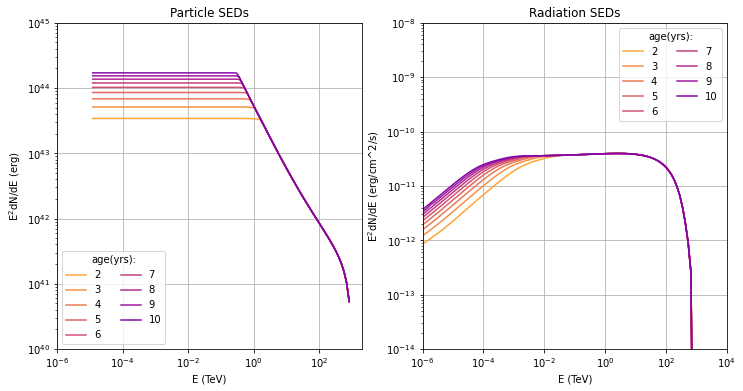

In [11]:
''' 
    Calculate the radiation spectrum from the previously calculated electron distribution
''' 

#### make a plot #####
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
ax1.set_prop_cycle('color',plt.get_cmap('plasma_r')(np.linspace(0.2, .8, len(time_steps))))  #
for p,t in list(zip(part[1:],time_steps[1:])):
    ax1.loglog(p[:,0],p[:,1],label=str(int(t)))
ax1.set_xlabel("E (TeV)")
ax1.set_ylabel("E"+r"$^2$"+"dN/dE (erg)")
ax1.grid()
ax1.legend(ncol=2,prop={'size':10},title="age(yrs):")
ax1.set_xlim(xmin=1e-6,xmax=2e3)
ax1.set_ylim(ymin=1e40,ymax=1e45)
ax1.set_title("Particle SEDs")

ax2.set_prop_cycle('color',plt.get_cmap('plasma_r')(np.linspace(0.2, .8, len(time_steps))))  #
for r,t in list(zip(rad[1:],time_steps[1:])):
    ax2.loglog(r[:,0],r[:,1],label=str(int(t)))
ax2.set_xlabel("E (TeV)")
ax2.set_ylabel("E"+r"$^2$"+"dN/dE (erg/cm^2/s)")
ax2.legend(ncol=2,prop={'size':10},title="age(yrs):")
ax2.grid()
ax2.set_xlim(xmin=1e-6,xmax=1e4)
ax2.set_ylim(ymin=1e-14,ymax=1e-8)
ax2.set_title("Radiation SEDs")
f.savefig("particles_static_timeseries.png",bbox_inches='tight')
